Importing a few things

In [10]:
# FUSEDWind imports
from fusedwind.plant_flow.vt import GenericWindFarmTurbineLayout, WTPC, WeibullWindRoseVT, GenericWindRoseVT


# Topfarm lib imports
from topfarm.aep import AEP
from topfarm.layout_distribution import spiral, DistributeSpiral, DistributeXY, DistributeFilledPolygon
from topfarm.plot import OffshorePlot, PrintOutputs, plot_wt_layout, plot_wind_rose
from topfarm.tlib import DistFromTurbines, PolyFill, document, DistFromBorders #,ConverHullArea
from topfarm.foundation import FoundationLength
from topfarm.elnet import ElNetLength, elnet
from topfarm.optimizers import *
from topfarm.topfarm import Topfarm

#GCL imports
from gclarsen.fusedwasp import PlantFromWWH, WTDescFromWTG
from gclarsen.fused import FGCLarsen

from numpy import *
import numpy as np

# For plotting
import pylab as plt

### Loading all the input data

In [11]:
datadir = './examples/notebook/'
dat = loadtxt(datadir+'WaterDepth1.dat')
X, Y = meshgrid(linspace(0., 1000., 50), linspace(0., 1000., 50))
depth = array(zip(X.flatten(), Y.flatten(), dat.flatten()))
borders = array([[200, 200], [150, 500], [200, 800], [600, 900], [700, 700], [900, 500], [800, 200], [500, 100], [200, 200]])
baseline = array([[587.5, 223.07692308], [525., 346.15384615], [837.5, 530.76923077], [525., 530.76923077], [525., 838.46153846], [837.5, 469.23076923]])

wt_desc = WTDescFromWTG(datadir+'V80-2MW-offshore.wtg').wt_desc
wt_layout = GenericWindFarmTurbineLayout([WTPC(wt_desc=wt_desc, position=pos) for pos in baseline])


# The wind rose
weibull_array = np.array([[  0.00000000e+00,   3.59673400e-02,  9.22422800e+00,   2.38867200e+00],
                         [  3.00000000e+01,   3.94977300e-02,   9.86435600e+00,   2.44726600e+00],
                         [  6.00000000e+01,   5.17838000e-02,   9.65220200e+00,   2.41992200e+00],
                         [  9.00000000e+01,   6.99794900e-02,   9.98217800e+00,   2.58789100e+00],
                         [  1.20000000e+02,   8.36383000e-02,   1.00946000e+01,   2.74804700e+00],
                         [  1.50000000e+02,   6.43412500e-02,   9.64369000e+00,   2.59179700e+00],
                         [  1.80000000e+02,   8.64220000e-02,   9.63377500e+00,   2.58007800e+00],
                         [  2.10000000e+02,   1.17690000e-01,   1.05678600e+01,   2.54492200e+00],
                         [  2.40000000e+02,   1.51555100e-01,   1.14525200e+01,   2.46679700e+00],
                         [  2.70000000e+02,   1.47361100e-01,   1.17423700e+01,   2.60351600e+00],
                         [  3.00000000e+02,   1.00109800e-01,   1.16923200e+01,   2.62304700e+00],
                         [  3.30000000e+02,   5.16542400e-02,   1.01385800e+01,   2.32226600e+00]])
wind_rose = WeibullWindRoseVT()
wind_rose.wind_directions = weibull_array[:,0]
wind_rose.frequency = weibull_array[:,1]
wind_rose.k = weibull_array[:,3]
wind_rose.A = weibull_array[:,2]

# Minimum distance between turbines
dist_WT_D = 3.0

# Plotting the inputs


Some matplotlib options

In [12]:
%matplotlib inline
import pylab as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
# To see all the options:
#plt.rcParams.keys()

#### Plotting the depth

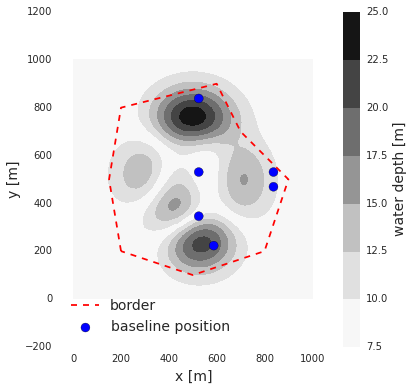

In [13]:
plot_wt_layout(wt_layout, borders, depth)

The red points indicate the position of the baseline turbines, the contour plot illustrate the water depth in meters and the red line illustrates the position of the borders limiting the domain of exploration of the optimization.

#### Plot the wind rose

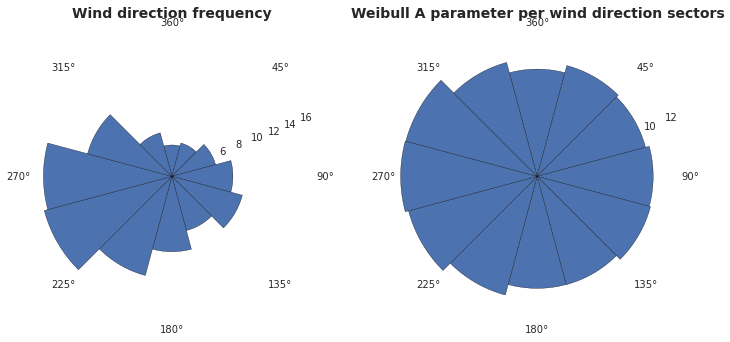

In [14]:
plot_wind_rose(wind_rose)

### Setting up TOPFARM

#### Calculating the wind farm AEP

In [15]:
ws = linspace(4, 25, 21)
wd = linspace(0, 360, 36)[:-1]

In [16]:
aep = AEP(wt_layout=wt_layout, 
          wind_rose=wind_rose, 
          wf=FGCLarsen(),
          wind_speeds=ws,
          wind_directions=wd,
          scaling=1.0,
          wt_positions=baseline)
aep.run()
print 'Net AEP=',aep.net_aep/1e6, 'MWh'

1.0
Net AEP= 50598.5402304 MWh


##### Exercise make a loop to plot the convergence of AEP vs the number of wind direction points

## Optimize only the foundation length

Here we don't consider the AEP for speeding things up.
The `components` dictionary contains the different models inside the workflow. The `components['driver']` is the optimizer. You can select other ones from this list: 

* CONMINOpt
* NEWSUMTOpt
* COBYLAOpt
* SLSQPOpt
* GeneticOpt


In [17]:
document(CONMINOpt)

INPUTS:
-------
conmin_diff = False 
	Set to True to let CONMINcalculate the gradient.
phi = 5.0 
	Participation coefficient - penalty parameter that pushes designs towards the feasible region.
iprint = 0 
	Print information during CONMIN solution. Higher values are more verbose. 0 suppresses all output.
fdchm = 1e-06 
	Minimum absolute step in finite difference gradient calculations (only when CONMIN calculates gradient).
gradient_options = <openmdao.main.driver.GradientOptions object at 0x7f8f22ea66b0> 
	None
dabfun = 0.001 
	Absolute convergence tolerance.
fdch = 1e-05 
	Relative change in parameters when calculating finite difference gradients (only when CONMIN calculates gradient).
directory =  
	If non-blank, the directory to execute in.
itrm = 3 
	Number of consecutive iterations to indicate convergence (relative or absolute).
icndir = 0.0 
	Conjugate gradient restart. parameter.
linobj = False 
	Linear objective function flag. Set to True if objective is linear.
ctl = -0.01 
	C

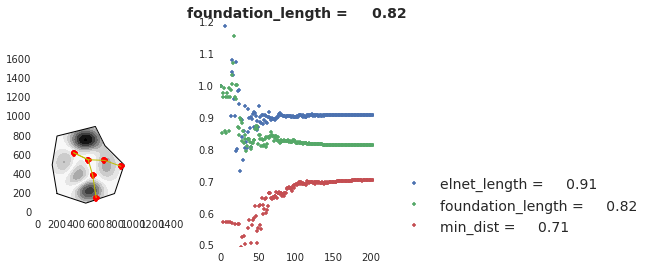

In [18]:
components = {
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'distribute': DistributeXY(wt_layout=wt_layout, borders=borders),
    'elnet': ElNetLength(scaling=0.0),
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy', 
                             add_inputs=['elnet_length', 'foundation_length', 'min_dist' ],
                             title='foundation_length'),
    'driver': COBYLAOpt(rhobeg=1)}

workflows =   {'driver': ['distribute', 'foundation','wt_dist', 'elnet', 'dist_from_borders', 'plotting']}

#objectives =  {'driver': 'foundation.foundation_length'}
objectives =  {'driver': '0.5 * foundation.foundation_length + 0.5*elnet.elnet_length'}

constraints = {'driver': ['wt_dist.min_dist>0.8', 
                          'elnet.elnet_length<1.1', 
                          'dist_from_borders'
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'wt_dist.wt_positions',
                                            'plotting.wt_positions',
                                           'elnet.wt_positions',
                                          'dist_from_borders.wt_positions'],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',               
               'wt_dist.min_dist': 'plotting.min_dist'}

input_parameters = {}

top = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top.run()

In [19]:
baseline = top.distribute.wt_positions

## Optimization using the AEP

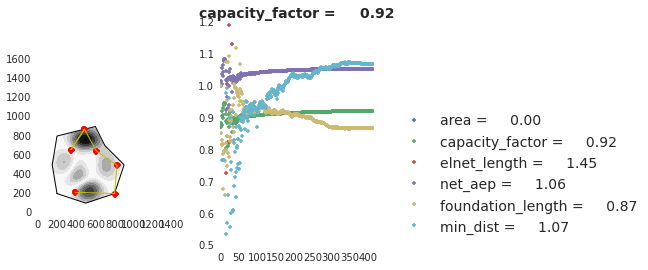

In [20]:
components = {
    'elnet': ElNetLength(scaling=0.0),
    'foundation': FoundationLength(borders=borders, scaling=0.0, depth=depth),
    'aep': AEP(wt_layout=wt_layout, 
               wind_rose=wind_rose, 
               wf=FGCLarsen(),
               wind_speeds=[4, 8, 12],
               wind_directions=linspace(0, 360, 12)[:-1],
               scaling=0.0),
    #'area': ConverHullArea(wt_layout=wt_layout, scaling=0.0),
    'dist_from_borders': DistFromBorders(wt_layout=wt_layout, borders=borders, scaling=0.0),    
    'wt_dist': DistFromTurbines(scaling=wt_desc.rotor_diameter * dist_WT_D),
    'distribute': DistributeXY(wt_layout=wt_layout, borders=borders),
    'plotting': OffshorePlot(baseline=baseline, borders=borders, depth=depth, distribution='xy',
                             add_inputs=['area', 'capacity_factor', 'elnet_length', 'net_aep', 'foundation_length', 'min_dist' ],
                             title='capacity_factor'),
    'driver': COBYLAOpt(rhobeg=1)}
workflows =   {'driver': ['distribute', 'foundation', 'elnet', 'aep', 'dist_from_borders', 'wt_dist', 'plotting']}

objectives =  {'driver': '-aep.net_aep'}
# objectives =  {'driver': '-aep.net_aep + 0.4*elnet.elnet_length'}
#objectives =  {'driver': '-aep.capacity_factor/area.area'}

constraints = {'driver': ['wt_dist.min_dist>0.8',
                          'foundation.foundation_length<1.02',
                         'dist_from_borders'
                         #'foundation.foundation_length<1.02',
                         #'elnet.elnet_length<1.02',
                          ]}

design_variables = {'driver': 'distribute'}

connections = {'distribute.wt_positions': ['foundation.wt_positions',
                                            'elnet.wt_positions',
                                            'wt_dist.wt_positions',
                                            'aep.wt_positions',
                                            'plotting.wt_positions',
                                           'dist_from_borders.wt_positions',
                                           #'area.wt_positions'
                                          ],
               'foundation.foundation_length': 'plotting.foundation_length',
               'foundation.foundations': 'plotting.foundations',
               'elnet.elnet_layout': 'plotting.elnet_layout',
               'elnet.elnet_length': 'plotting.elnet_length',
               'wt_dist.min_dist': 'plotting.min_dist',
               'aep.capacity_factor': 'plotting.capacity_factor',
               'aep.net_aep': 'plotting.net_aep',
               #'area.area': 'plotting.area'
              }

input_parameters = {}
top2 = Topfarm(components, workflows, objectives, constraints, design_variables, connections, input_parameters)
top2.run()

Copying the new positions of the turbines

In [21]:
baseline = top2.distribute.wt_positions

Plotting the new positions

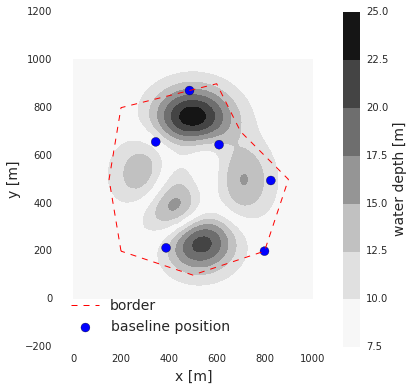

In [22]:
plot_wt_layout(wt_layout, borders, depth)

Calculating the new AEP with a higher wind rose accuracy

In [23]:
ws = linspace(4, 25, 21)
wd = linspace(0, 360, 181)[:-1]
aep = AEP(wt_layout=wt_layout, 
          wind_rose=wind_rose, 
          wf=FGCLarsen(),
          wind_speeds=ws,
          wind_directions=wd,
          scaling=1.0,
          wt_positions=baseline)
aep.run()
print 'Net AEP=',aep.net_aep/1e6, 'MWh'

1.0
Net AEP= 53095.5225994 MWh
